In [1]:
import os
import shutil

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

train_list = os.listdir('train')

train_cat = filter(lambda x:x[:3] == 'cat', train_list)
train_dog = filter(lambda x:x[:3] == 'dog', train_list)

def mkdir(path):
    folder = os.path.exists(path)
    if folder:
        shutil.rmtree(path)
    os.mkdir(path)

train_symlink_path = 'train-symlink'
test_symlink_path = 'test-symlink'
    
mkdir(train_symlink_path)

os.mkdir(train_symlink_path + '/cat')
for filename in train_cat:
    os.symlink('../../train/' + filename, train_symlink_path + '/cat/' + filename)

os.mkdir(train_symlink_path + '/dog')
for filename in train_dog:
    os.symlink('../../train/' + filename, train_symlink_path + '/dog/' + filename)

mkdir(test_symlink_path)
os.symlink('../test/', test_symlink_path + '/test')

导出特征向量

为了提高模型的表现，本项目决定使用预训练网络，最终选择了ResNet50, Xception, Inception V3 这三个模型，每个模型导出的时间都挺长。 这三个模型都是在 ImageNet 上面预训练过的，所以每一个模型都可以说是身经百战。我们可以将多个不同的网络输出的特征向量先保存下来，后续即使是在普通笔记本上也能轻松训练。

In [2]:
from keras import Input, Model
from keras.applications import ResNet50, InceptionV3, inception_v3, Xception, xception
from keras.layers import Lambda, GlobalAveragePooling2D
from keras_preprocessing.image import ImageDataGenerator

import h5py
import math

def write_gap(MODEL, image_size, lambda_func=None):
    input_tensor = Input(shape=(image_size[0], image_size[1], 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
         
    base_model = MODEL( include_top=False, weights='imagenet', input_tensor=x)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train-symlink", image_size, shuffle=False, 
                                              batch_size=32)
    test_generator = gen.flow_from_directory("test-symlink", image_size, shuffle=False, 
                                             batch_size=32, class_mode=None)

    train = model.predict_generator(train_generator, math.ceil(train_generator.samples*1.0/train_generator.batch_size), verbose=1)
    test = model.predict_generator(test_generator, math.ceil(test_generator.samples*1.0/test_generator.batch_size), verbose=1)
    
    if MODEL == ResNet50:
        model_name = "gap_ResNet50.h5"
    elif MODEL == Xception:
        model_name = "gap_Xception.h5"
    elif MODEL == InceptionV3:
        model_name = "gap_InceptionV3.h5"
        
    with h5py.File(model_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

Using TensorFlow backend.


In [33]:
write_gap(ResNet50, (224, 224))

/anaconda3/envs/Python37/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
391/391 [==============================] - 1692s 4s/step


In [34]:
write_gap(Xception, (299, 299), xception.preprocess_input)

83689472/83683744 [==============================] - 204s 2us/step
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
391/391 [==============================] - 5768s 15s/step


In [35]:
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
391/391 [==============================] - 1671s 4s/step


载入特征向量

现在我们获得了3个特征向量文件：

- gap_ResNet50.h5
- gap_Xception.h5
- gap_InceptionV3.h5

我们需要载入这些特征向量，并且将它们合成一条特征向量，然后记得把 X 和 y 打乱，不然之后我们设置validation_split的时候会出问题。这里设置了 numpy 的随机数种子为2019，这样可以确保每个人跑这个代码，输出都能是一样的结果。

In [3]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2019)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [4]:
from keras.models import *
from keras.layers import Dropout
from keras.layers import Dense

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


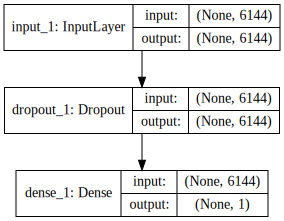

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
fit = model.fit(X_train, y_train, batch_size=128, epochs=8, validation_split=0.2, verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 6s 289us/step - loss: 0.0101 - acc: 0.9965 - val_loss: 0.0181 - val_acc: 0.9952
Epoch 2/8
20000/20000 [==============================] - 6s 303us/step - loss: 0.0095 - acc: 0.9972 - val_loss: 0.0183 - val_acc: 0.9948
Epoch 3/8
20000/20000 [==============================] - 6s 286us/step - loss: 0.0084 - acc: 0.9970 - val_loss: 0.0188 - val_acc: 0.9952
Epoch 4/8
20000/20000 [==============================] - 6s 291us/step - loss: 0.0081 - acc: 0.9972 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 5/8
20000/20000 [==============================] - 6s 301us/step - loss: 0.0080 - acc: 0.9974 - val_loss: 0.0191 - val_acc: 0.9952
Epoch 6/8
20000/20000 [==============================] - 6s 305us/step - loss: 0.0076 - acc: 0.9973 - val_loss: 0.0203 - val_acc: 0.9948
Epoch 7/8
20000/20000 [==============================] - 6s 293us/step - loss: 0.0081 - acc: 0.9975 - val_loss: 0.0195 - val_acc:

In [16]:
model.save('model.h5')

In [17]:
y_pred = model.predict(X_test, verbose=2)
y_pred = y_pred.clip(min=0.005, max=0.995)

In [18]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test-symlink", (224, 224), shuffle=False,
                                         batch_size=32, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)

df.head(10)

Found 12500 images belonging to 1 classes.


/anaconda3/envs/Dogs-vs-cats/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
